In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.linear_model import SGDOneClassSVM
from sklearn.metrics import roc_auc_score
from tqdm import tqdm, trange

from dataset import Dataset, get_transac_n_seconds
from models import Classifier, Projector, VAE
from trainers.drocc_trainer import DROCCTrainer, adjust_learning_rate
from trainers.dsvdd_trainer import DeepSVDD
from trainers.vae_trainer import LossVAE

In [6]:
#df = pd.read_csv('~/Bureau/Datasets/TimeSeries/creditcard.csv')
df = pd.read_csv('creditcard.csv')
df.head()

DEVICE="mps"
BATCH_SIZE=256

In [7]:
normal_rate = len(df[df['Class']==0])/ len(df)
anormal_rate = len(df[df['Class']==1])/ len(df)

print(f"normal rate: {normal_rate} ; anormal rate: {anormal_rate}")

normal rate: 0.9982725143693799 ; anormal rate: 0.001727485630620034


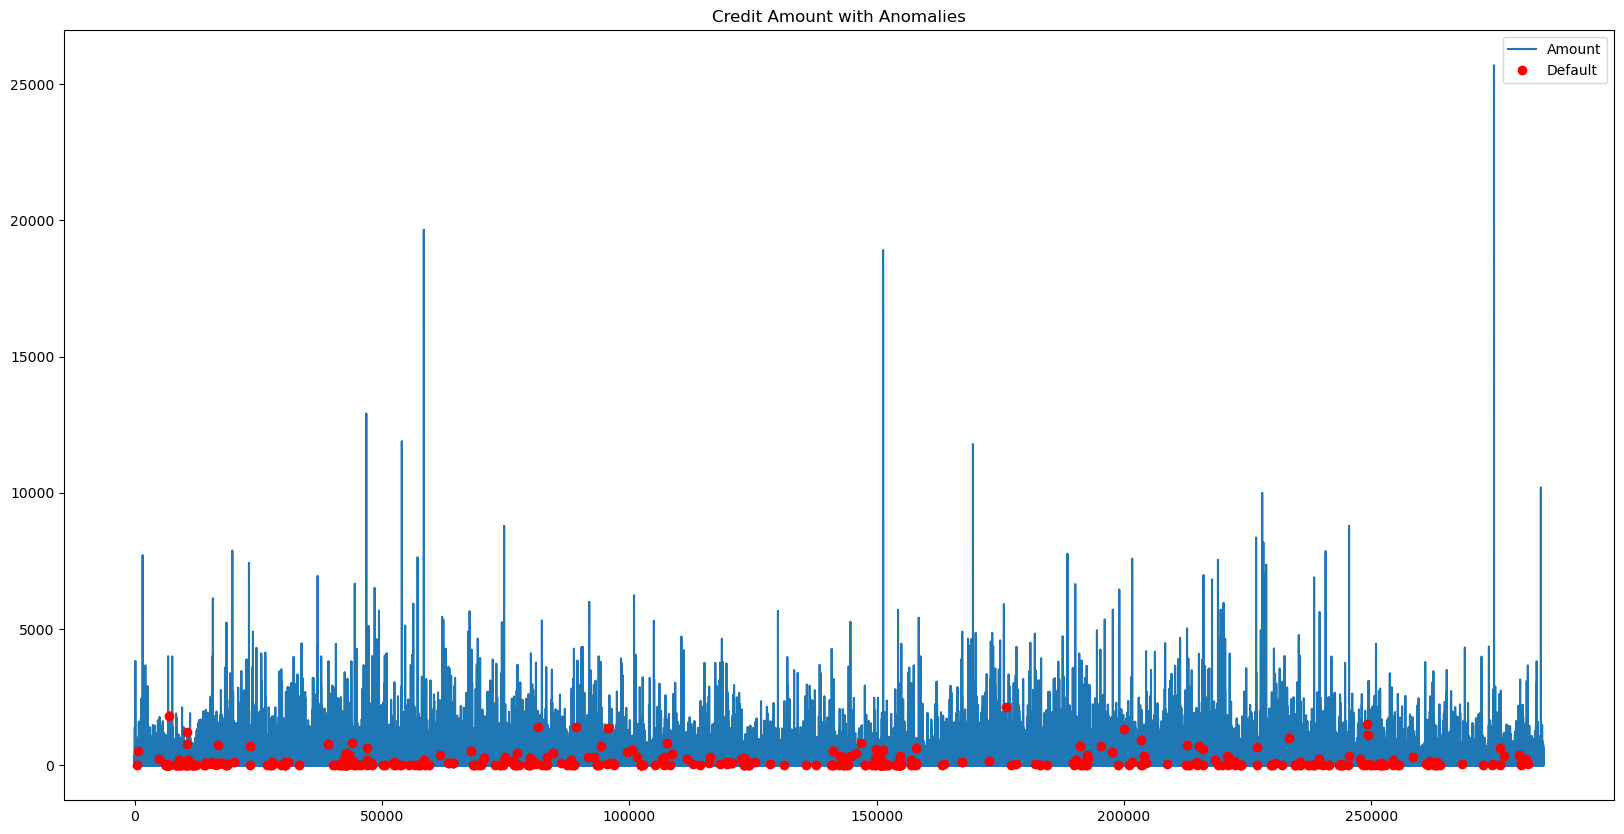

In [8]:
plt.figure(figsize=(20, 10))

value = df['Amount']
anomalies = df['Class']

indices = range(len(value))
anomalies_indices = [i for i in df[df['Class']==1].index]

plt.plot(indices, value, label='Amount')
plt.plot( anomalies_indices, value[anomalies_indices], "ro", label='Default')
plt.title('Credit Amount with Anomalies')
plt.legend()

# Supervised Setting

In [9]:
dataset = get_transac_n_seconds(df, seconds=1) # Takes 10 sec approx

train_size = int(0.6*len(dataset))

train = dataset.iloc[:train_size]
test = dataset.iloc[train_size:]

scaler = StandardScaler()

train = train.copy()
test = test.copy()

train['Amount'] = scaler.fit_transform(train['Amount'].values.reshape(-1, 1))
test['Amount'] = scaler.transform(test['Amount'].values.reshape(-1, 1))

### Basic DNN Classifier

In [10]:
BATCH_SIZE=256
EPOCHS=2
LR=1e-3

In [11]:
trainset = Dataset(train)
testset = Dataset(test)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = Classifier().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [12]:
for epoch in range(EPOCHS):
    epoch_loss = 0
    batch_pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{EPOCHS} Batches", leave=False)  # Inner progress bar for batches
    for inputs, targets in batch_pbar:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        preds = model(inputs)
        preds = torch.squeeze(preds, dim=1)
        targets = targets.float()
        loss = criterion(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Optionally update the inner pbar with the current loss
        batch_pbar.set_postfix(loss=loss.item())

    # Optionally update the outer pbar with the epoch loss
    print(f"epoch loss : {loss.item()/len(trainloader)}")

epoch loss : 2.9121716241882055e-06


epoch loss : 1.0639245929977226e-06


In [13]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        preds = model(test_batch).squeeze()
        preds = torch.sigmoid(preds)
        all_preds.append(preds.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score_supervised = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score_supervised}")

100%|██████████| 446/446 [00:01<00:00, 254.86it/s]


ROC-AUC score: 0.9390000087880414


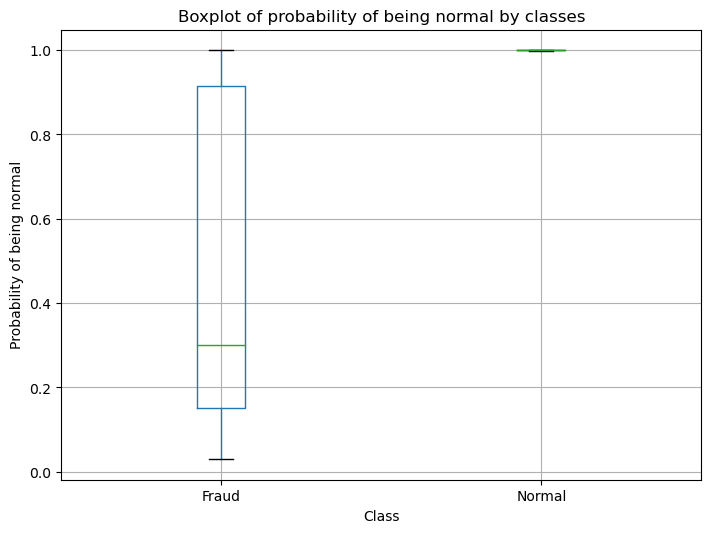

In [16]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

plt.title("Boxplot of probability of being normal by classes")
plt.suptitle("") 
plt.xlabel("Class")
plt.ylabel("Probability of being normal")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

plt.show()

# Unsupervised Setting

In [17]:
dataset = df.copy()

train_size = int(0.6 * len(dataset))
train = dataset.iloc[:train_size]
test = dataset.iloc[train_size:]
train = train[train['Class'] == 0]

new_train_size = len(train)

dataset = pd.concat([train, test], ignore_index=True)
dataset = get_transac_n_seconds(dataset, seconds=2)

train = dataset.iloc[:new_train_size]
test = dataset.iloc[new_train_size:]

scaler = StandardScaler()

train, test = train.copy(), test.copy()

train['Amount'] = scaler.fit_transform(train['Amount'].values.reshape(-1, 1))
test['Amount'] = scaler.transform(test['Amount'].values.reshape(-1, 1))

trainset = Dataset(train)
testset = Dataset(test)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

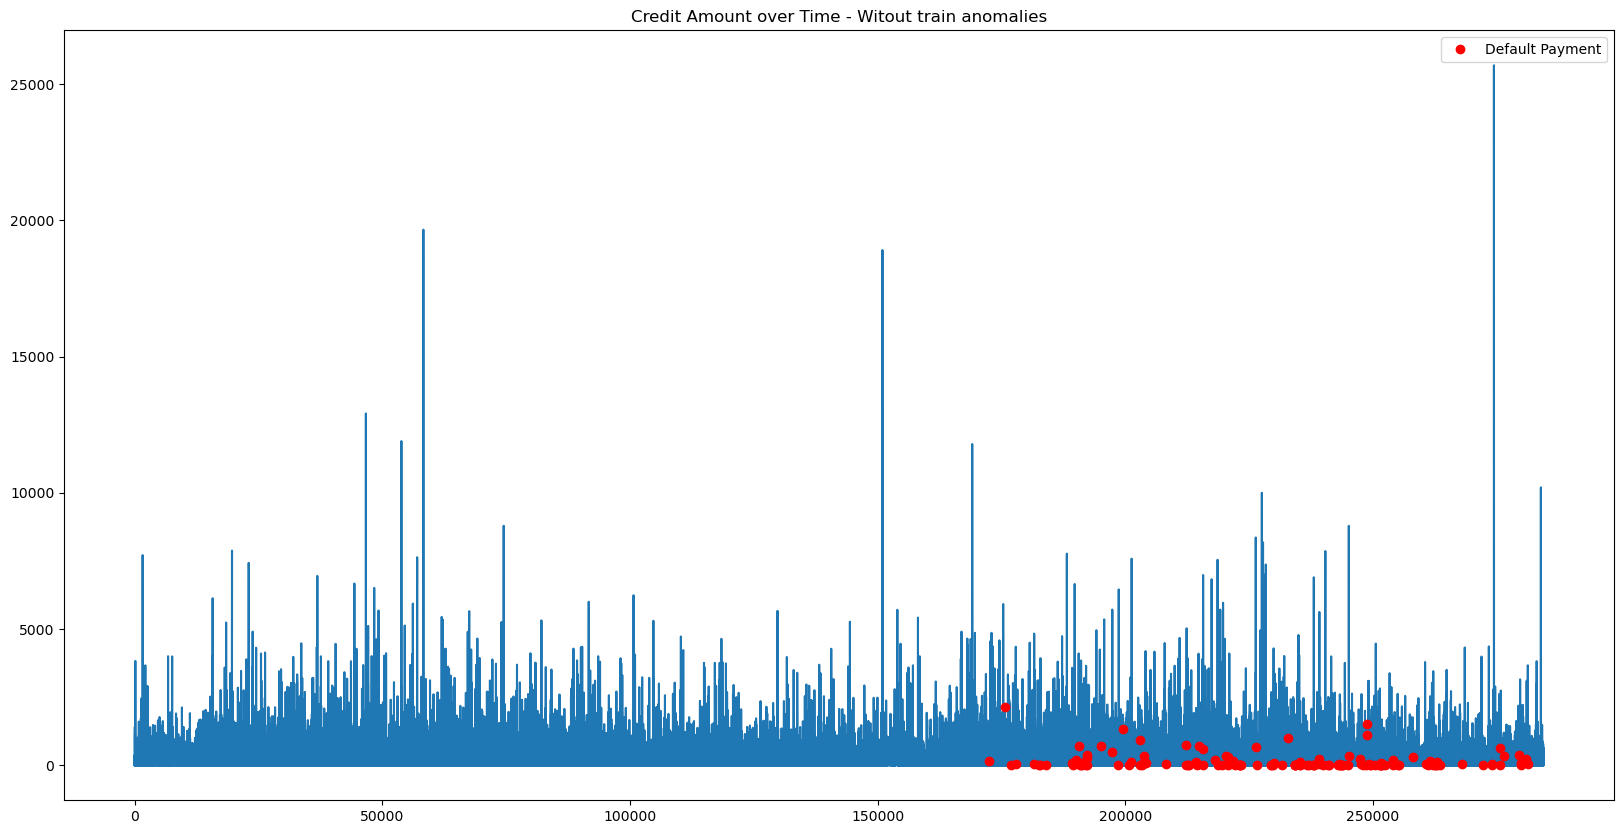

In [18]:
plt.figure(figsize=(20, 10))

value = dataset['Amount']
anomalies = dataset['Class']

indices = range(len(value))
anomalies_indices = [i for i in dataset[dataset['Class']==1].index]

plt.plot(indices, value)
plt.plot( anomalies_indices, value[anomalies_indices], "ro", label="Default Payment")
plt.title("Credit Amount over Time - Witout train anomalies")
plt.legend()

### SGD OC-SVM

In [19]:
X_train = train.drop(['Time', 'Class'], axis=1)
X_test = test.drop(['Time', 'Class'], axis=1)
y_test = test['Class']

In [20]:
clf = SGDOneClassSVM().fit(X_train)
prediction = clf.predict(X_test)

prediction = clf.predict(X_test)
prediction = np.where(prediction == -1, 1, 0)

score_svm = roc_auc_score(y_test, prediction)
print(f"ROC-AUC score: {score_svm}")

ROC-AUC score: 0.4888665503982181


### Deep SVDD

In [21]:
LR=1e-3
EPOCHS=10
BATCH_SIZE=256
WEIGHT_DECAY=1e-6
PROJ_DIM=32

In [22]:
model = Projector(proj_dim=PROJ_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=0.1)

In [23]:
svdd = DeepSVDD(model=model, proj_dim=PROJ_DIM, device=DEVICE)
center = svdd.initialize_center(trainloader=trainloader)
results = svdd.train(trainloader=trainloader, epochs=EPOCHS, optimizer=optimizer, scheduler=scheduler)

model = results["model"]
center = results["center"]

Training: 100%|██████████| 667/667 [00:04<00:00, 141.63it/s]


Epoch 1/10 ; Loss: 1.1776


Training: 100%|██████████| 667/667 [00:04<00:00, 150.12it/s]


Epoch 2/10 ; Loss: 0.3969


Training: 100%|██████████| 667/667 [00:04<00:00, 154.41it/s]


Epoch 3/10 ; Loss: 0.2074


Training: 100%|██████████| 667/667 [00:04<00:00, 154.92it/s]


Epoch 4/10 ; Loss: 0.1334


Training: 100%|██████████| 667/667 [00:04<00:00, 158.76it/s]


Epoch 5/10 ; Loss: 0.0925


Training: 100%|██████████| 667/667 [00:04<00:00, 160.73it/s]


Epoch 6/10 ; Loss: 0.0668


Training: 100%|██████████| 667/667 [00:04<00:00, 155.70it/s]


Epoch 7/10 ; Loss: 0.0498


Training: 100%|██████████| 667/667 [00:04<00:00, 158.74it/s]


Epoch 8/10 ; Loss: 0.0384


Training: 100%|██████████| 667/667 [00:04<00:00, 155.76it/s]


Epoch 9/10 ; Loss: 0.0303


Training: 100%|██████████| 667/667 [00:04<00:00, 155.27it/s]

Epoch 10/10 ; Loss: 0.0245


In [24]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        proj = model(test_batch)
        dist = torch.sum((proj - center) ** 2, dim=1)
        all_preds.append(-dist.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score_dsvdd = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score_dsvdd}")

100%|██████████| 446/446 [00:01<00:00, 233.54it/s]

ROC-AUC score: 0.9416114551318566


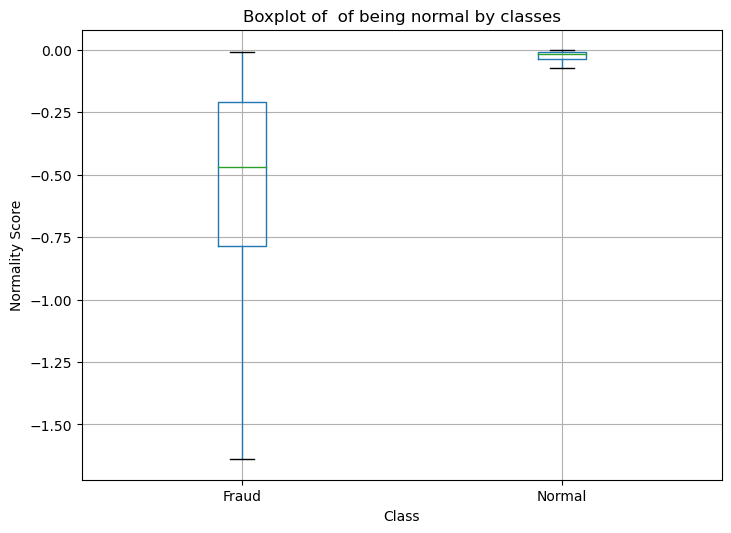

In [26]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

# Ajouter des labels et un titre
plt.title("Boxplot of  of being normal by classes")
plt.suptitle("")  # Supprime le titre automatique de pandas
plt.xlabel("Class")
plt.ylabel("Normality Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

# Afficher le graphique
plt.show()

### DROCC

In [27]:
LR=1e-3
EPOCHS=4
BATCH_SIZE=256

CE_EPOCHS=1
ASCENT_STEP_SIZE=0.1
ASCENT_NUM_STEPS=50

GAMMA=2
LAMBDA=1
RADIUS=5

In [28]:
model = Classifier().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [29]:
trainer = DROCCTrainer(model, optimizer, lamda=LAMBDA, radius=RADIUS, gamma=GAMMA, device=DEVICE)
trainer.train(trainloader, learning_rate=LR, lr_scheduler=adjust_learning_rate, total_epochs=EPOCHS,
             ascent_step_size=ASCENT_STEP_SIZE, ascent_num_steps=ASCENT_NUM_STEPS, only_ce_epochs = CE_EPOCHS)

model = trainer.get_model()

100%|██████████| 667/667 [00:05<00:00, 126.31it/s]


Epoch: 0, CE Loss: 0.028261180967092514, AdvLoss: 0.0


100%|██████████| 667/667 [01:35<00:00,  6.95it/s]


Epoch: 1, CE Loss: 0.7438111901283264, AdvLoss: 0.976934015750885


100%|██████████| 667/667 [01:32<00:00,  7.18it/s]


Epoch: 2, CE Loss: 0.7012759447097778, AdvLoss: 0.643173098564148


100%|██████████| 667/667 [01:32<00:00,  7.23it/s]

Epoch: 3, CE Loss: 0.6866199374198914, AdvLoss: 0.646531343460083


In [30]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        preds = torch.sigmoid(model(test_batch).squeeze())
        all_preds.append(preds.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score_drocc = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score_drocc}")

100%|██████████| 446/446 [00:01<00:00, 252.64it/s]

ROC-AUC score: 0.9567698941946465


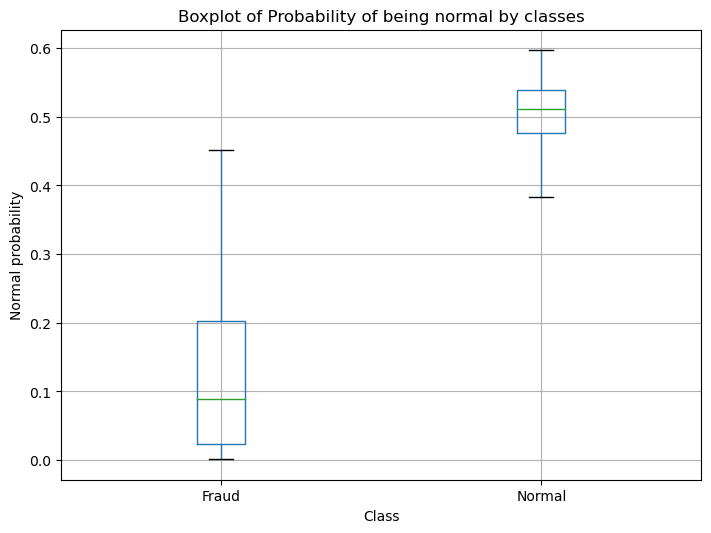

In [31]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

# Ajouter des labels et un titre
plt.title("Boxplot of Probability of being normal by classes")
plt.suptitle("")  # Supprime le titre automatique de pandas
plt.xlabel("Class")
plt.ylabel("Normal probability")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

# Afficher le graphique
plt.show()

### VAE - Reconstruction Loss

In [32]:
LR=1e-4
EPOCHS=10
BATCH_SIZE=256
LATENT_DIM=32

In [33]:
model = VAE(in_dim=30, hidden_dims=[128, 128], latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = LossVAE()

In [34]:
pbar = trange(EPOCHS, desc="Training")
for epoch in pbar:
    epoch_loss = 0

    for inputs, targets in trainloader:
        inputs = inputs.to(DEVICE)
        reconstructed, mu, logvar = model(inputs)
        loss = criterion(inputs, reconstructed, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss+=loss.item()

    epoch_loss = epoch_loss/len(trainloader)
    pbar.set_description(f"epoch : {epoch} ; loss : {epoch_loss}")

epoch : 9 ; loss : 13121.165984146599: 100%|██████████| 10/10 [02:02<00:00, 12.23s/it]


In [35]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        reconstructed, mu, logvar = model(test_batch)
        loss = torch.sum((test_batch - reconstructed) ** 2, dim=1) -0.5 * torch.sum(1+logvar - mu**2 - logvar.exp(), dim=1)
        all_preds.append(-loss.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score_vae = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score_vae}")

100%|██████████| 446/446 [00:02<00:00, 154.55it/s]

ROC-AUC score: 0.9182586336513273


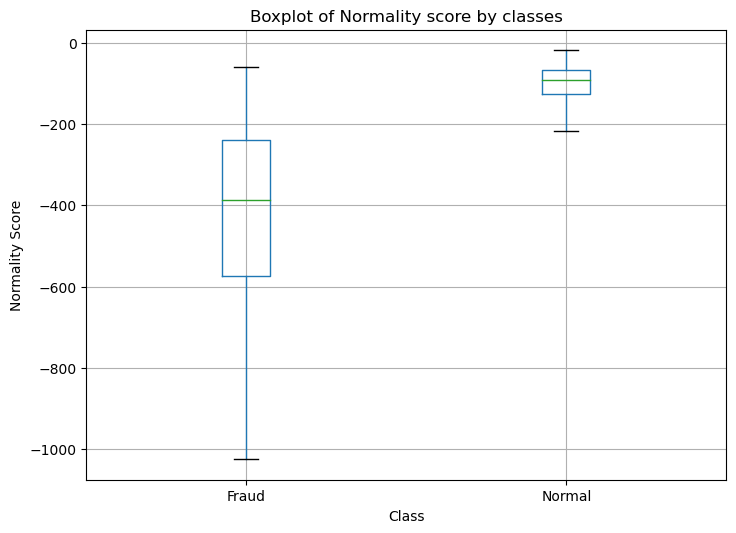

In [36]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

# Ajouter des labels et un titre
plt.title("Boxplot of Normality score by classes")
plt.suptitle("")  # Supprime le titre automatique de pandas
plt.xlabel("Class")
plt.ylabel("Normality Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

# Afficher le graphique
plt.show()

# Results Analysis: AUC Scores

In [45]:
auc_scores = pd.DataFrame(
    {
        "Basic NN Supervised": [score_supervised],
        "One-Class SVM SGD": [score_svm],
        "Deep SVDD": [score_dsvdd],
        "DROCC": [score_drocc],
        "VAE": [score_vae]
    },
    index=["ROC-AUC Scores: "]
) 
auc_scores

,Basic NN Supervised,One-Class SVM SGD,Deep SVDD,DROCC,VAE
ROC-AUC Scores:,0.939,0.488867,0.941611,0.95677,0.918259
